In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import arviz as az
import pandas as pd
from datetime import datetime
import json
import argparse


import torch
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
from pyro.infer.inspect import get_dependencies
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

import scipy.io
from scipy.stats import zscore
from sklearn.manifold import TSNE

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans



/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting Backend To: AvailableBackends.numpy


In [ ]:
parser = argparse.ArgumentParser(description='pass values using command line')
parser.add_argument('--startval', metavar='startcol', type=int, default=19,  help='start x column value')
parser.add_argument('--endval', metavar='endcol', type=int, default=21, help='end x column value')
parser.add_argument('--cluster', metavar='cluster', type=int, default=6, help='total number of cluster')
parser.add_argument('--dimred', metavar='dimred', type=str , default="pca", help='type of dimensionality reduction')
parser.add_argument('--plot_dimred', metavar='plot_dimred', type=str , default="tsne", help='type of dimensionality reduction for plotting after data is alread reduced in a smaller dimension')
parser.add_argument('--prior_number_samples', metavar='prior_number_samples', type=int , default=100, help='number of samples for prior')
parser.add_argument('--posterior_number_samples', metavar='posterior_number_samples', type=int , default=150, help='number of samples for posterior')
parser.add_argument('--posterior_warmup_steps', metavar='posterior_warmup_steps', type=int , default=50, help='number of  warmup steps for posterior')

def cluster_acc(Y_pred, Y, ignore_label=None):
    """ Rearranging the class labels of prediction so that it maximise the 
        match class labels.

    Args:
        Y_pred (int): An array for predicted labels
        Y (float): An array for true labels
        ignore_label (int, optional): Laels to be ignored

    Returns:
       row (int): A list of index of row 
       column (int) : A list of index of column
       accuracy (float): accuracy after we found correct label
       cost_matrix (int) : cost matrix 
    """
    if ignore_label is not None:
        index = Y!= ignore_label
        Y=Y[index]
        Y_pred=Y_pred[index]
    from scipy.optimize import linear_sum_assignment as linear_assignment
    assert Y_pred.shape == Y.shape
    D = int((max(Y_pred.max(), Y.max())).item())
    w = torch.zeros((D, D))
    for i in range(Y_pred.shape[0]):
        w[int(Y_pred[i].item())-1, int(Y[i].item())-1] += 1
    ind = linear_assignment(w.max() - w)
    return ind[0], ind[1], (w[ind[0], ind[1]]).sum() / Y_pred.shape[0], w

def TSNE_transformation(data, label, filename):
    """ This function applies TSNE algorithms to reduce the high dimensional data into 2D
        for better visualization

    Args:
        data (float): High dimensional Input data 
        label (int): Label information of each data entry
        filename (str): Location to store the image after dimensionality reduction
    """
    from sklearn.manifold import TSNE
    model = TSNE(n_components=2, random_state=42)
    transformed_data = model.fit_transform(data) 
    label_to_color = { 1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5: 'orange', 6: 'purple'}
    plt.figure(figsize=(10,8))
    for label_ in np.unique(label):
        idx =label ==label_
        plt.scatter(transformed_data[idx][:,0],transformed_data[idx][:,1], c=label_to_color[label_],label=f' {label_}',s=50, marker='o',alpha=1.0, edgecolors='w')
    # Create a legend
    plt.legend()
    # Add axis labels
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title("Data after dimensionality reduction")
    
    plt.savefig(filename)
    
def create_initial_gempy_model(refinement,save=True):
    """ Create an initial gempy model objet

    Args:
        refinement (int): Refinement of grid
        save (bool, optional): Whether you want to save the image

    """
    geo_model_test = gp.create_geomodel(
    project_name='Gempy_abc_Test',
    extent=[0, 86, -10, 10, -83, 0],
    resolution=[86,20,83],
    refinement=refinement,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )

    gp.add_surface_points(
        geo_model=geo_model_test,
        x=[70.0, 80.0],
        y=[0.0, 0.0],
        z=[-77.0, -71.0],
        elements_names=['surface1', 'surface1']
    )

    gp.add_orientations(
        geo_model=geo_model_test,
        x=[75],
        y=[0.0],
        z=[-74],
        elements_names=['surface1'],
        pole_vector=[[-5/3, 0, 1]]
    )
    geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)

    element2 = gp.data.StructuralElement(
        name='surface2',
        color=next(geo_model_test.structural_frame.color_generator),
        surface_points=gp.data.SurfacePointsTable.from_arrays(
            x=np.array([20.0, 60.0]),
            y=np.array([0.0, 0.0]),
            z=np.array([-74, -52]),
            names='surface2'
        ),
        orientations=gp.data.OrientationsTable.initialize_empty()
    )

    geo_model_test.structural_frame.structural_groups[0].append_element(element2)

    element3 = gp.data.StructuralElement(
        name='surface3',
        color=next(geo_model_test.structural_frame.color_generator),
        surface_points=gp.data.SurfacePointsTable.from_arrays(
            x=np.array([0.0, 30.0, 60]),
            y=np.array([0.0, 0.0,0.0]),
            z=np.array([-72, -55.5, -39]),
            names='surface3'
        ),
        orientations=gp.data.OrientationsTable.initialize_empty()
    )

    geo_model_test.structural_frame.structural_groups[0].append_element(element3)

    element4 = gp.data.StructuralElement(
        name='surface4',
        color=next(geo_model_test.structural_frame.color_generator),
        surface_points=gp.data.SurfacePointsTable.from_arrays(
            x=np.array([0.0, 20.0, 60]),
            y=np.array([0.0, 0.0,0.0]),
            z=np.array([-61, -49, -27]),
            names='surface4'
        ),
        orientations=gp.data.OrientationsTable.initialize_empty()
    )

    geo_model_test.structural_frame.structural_groups[0].append_element(element4)

    element5 = gp.data.StructuralElement(
        name='surface5',
        color=next(geo_model_test.structural_frame.color_generator),
        surface_points=gp.data.SurfacePointsTable.from_arrays(
            x=np.array([0.0, 20.0, 40]),
            y=np.array([0.0, 0.0, 0.0]),
            z=np.array([-39, -28, -16]),
            names='surface5'
        ),
        orientations=gp.data.OrientationsTable.initialize_empty()
    )

    geo_model_test.structural_frame.structural_groups[0].append_element(element5)

    element6 = gp.data.StructuralElement(
        name='surface6',
        color=next(geo_model_test.structural_frame.color_generator),
        surface_points=gp.data.SurfacePointsTable.from_arrays(
            x=np.array([0.0, 20.0,30]),
            y=np.array([0.0, 0.0, 0.0]),
            z=np.array([-21, -10, -1]),
            names='surface6'
        ),
        orientations=gp.data.OrientationsTable.initialize_empty()
    )

    geo_model_test.structural_frame.structural_groups[0].append_element(element6)

    geo_model_test.structural_frame.structural_groups[0].elements[0], geo_model_test.structural_frame.structural_groups[0].elements[1],\
    geo_model_test.structural_frame.structural_groups[0].elements[2], geo_model_test.structural_frame.structural_groups[0].elements[3],\
    geo_model_test.structural_frame.structural_groups[0].elements[4], geo_model_test.structural_frame.structural_groups[0].elements[5] = \
    geo_model_test.structural_frame.structural_groups[0].elements[1], geo_model_test.structural_frame.structural_groups[0].elements[0],\
    geo_model_test.structural_frame.structural_groups[0].elements[3], geo_model_test.structural_frame.structural_groups[0].elements[2],\
    geo_model_test.structural_frame.structural_groups[0].elements[5], geo_model_test.structural_frame.structural_groups[0].elements[4]  


    gp.compute_model(geo_model_test)
    picture_test = gpv.plot_2d(geo_model_test, cell_number=5, legend='force')
    if save:
        plt.savefig("./Result_with_wishart/Prior_model.png")
    
    return geo_model_test
    


Intial accuracy
 tensor(0.7056)
Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(


Setting Backend To: AvailableBackends.numpy
Active grids: ['custom']
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.PYTORCH


/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(


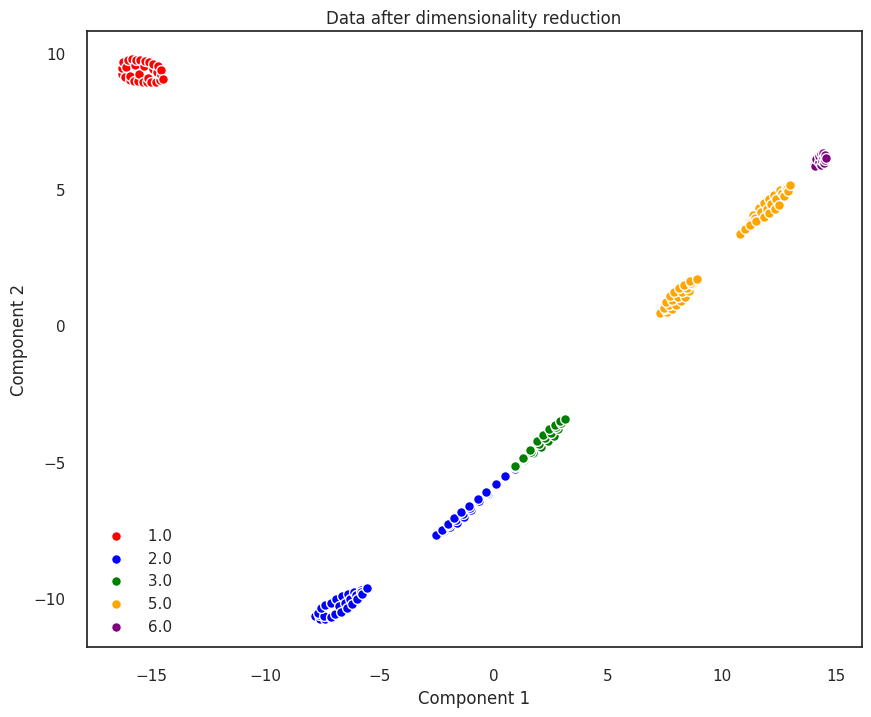

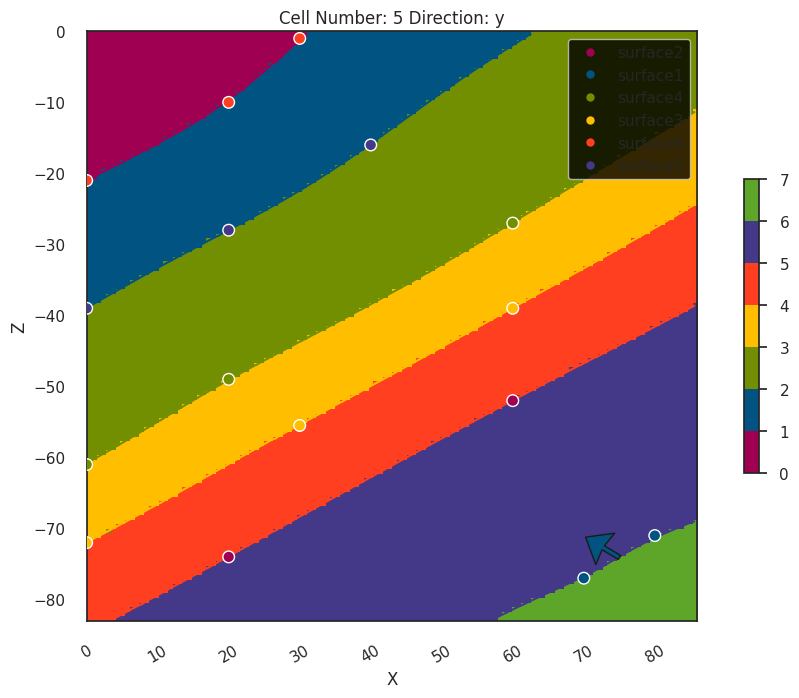

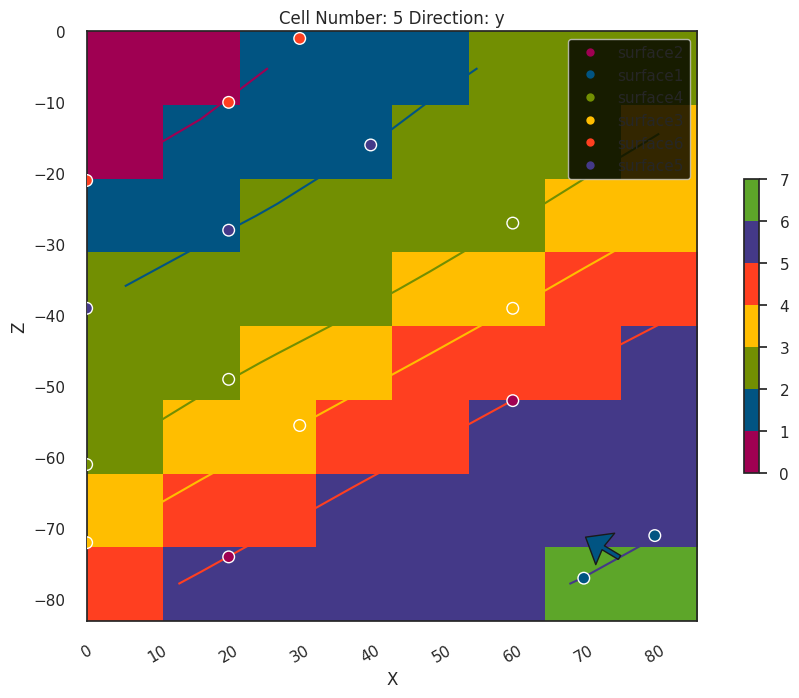

In [3]:

"""
This function defines a model which uses hyperspectral data, applies clustering methods to find cluster information and then uses Bayesian
"""
# args = parser.parse_args()
# startval=args.startval
# endval=args.endval
# dimred=args.dimred
# cluster = args.cluster
# plot_dimred=args.plot_dimred
# prior_number_samples = args.prior_number_samples
# posterior_number_samples = args.posterior_number_samples
# posterior_warmup_steps = args.posterior_warmup_steps

startval=19
endval=21
dimred='pca'
cluster = 6
plot_dimred="tsne"


# Load .mat file
SalinasA= np.array(scipy.io.loadmat('./HSI_Salinas/SalinasA.mat')['salinasA'])
SalinasA_corrected= np.array(scipy.io.loadmat('./HSI_Salinas/SalinasA_corrected.mat')['salinasA_corrected'])
SalinasA_gt= np.array(scipy.io.loadmat('./HSI_Salinas/SalinasA_gt.mat')['salinasA_gt'])
# Arrange the label in groundtruth
i=0
label_data = [0,6,1,5,4,3,2]

for ele in np.unique(SalinasA_gt):
    mask = SalinasA_gt==ele
    SalinasA_gt[mask] = label_data[i]
    i=i+1
SalinasA_gt = 7 - SalinasA_gt
######################################################################
## Arrange Data as concatationation of spacial co-ordinate and pixel values
###########################################################################
H, W = SalinasA_gt.shape # get the shape of groud truth
n_features = SalinasA_corrected.shape[2]+4 # get the number of features including co-ordinates and label

# Create a dataset which has "X","Y","Z", "Label", and spectral channel information
data_hsi = torch.zeros((H*W, n_features ))
for i in range(H):
    for j in range(W):
        data_hsi[i*W+j,0] = j
        data_hsi[i*W +j,2] = - i
        data_hsi[i*W +j,3] = SalinasA_gt[i,j]
        data_hsi[i*W +j,4:] = torch.tensor(SalinasA_corrected[i,j,:])
        
# Create a list of column name
column_name=["X","Y","Z", "Label"]
for i in range(SalinasA_corrected.shape[2]):
    column_name.append("feature_"+str(i+1))
    
# Create a pandas dataframe to store the database
df_hsi = pd.DataFrame(data_hsi,columns=column_name)
# Create a database by removing the non labelled pixel information 
df_with_non_labelled_pixel = df_hsi.loc[(df_hsi['Label']!=7)]

# Normalise along the spectral lines 
df_with_spectral_normalised = df_with_non_labelled_pixel.copy()
df_with_spectral_normalised.iloc[:, 4:] = df_with_spectral_normalised.iloc[:, 4:].apply(zscore,axis=1)


# column = 20
# y_obs = torch.tensor(SalinasA_gt[:,column], dtype=torch.float64)
# mask = y_obs!=0
# y_obs_label = y_obs[mask]
# y_obs_hsi = torch.tensor(SalinasA_corrected[:,column,:], dtype=torch.float64)[mask]

# normalised_hsi = zscore(y_obs_hsi, axis=1)


###########################################################################
## Obtain the preprocessed data
###########################################################################
normalised_data = df_with_spectral_normalised.loc[(df_with_spectral_normalised["X"]>=startval)&(df_with_spectral_normalised["X"]<=endval)]
normalised_hsi =torch.tensor(normalised_data.iloc[:,4:].to_numpy(), dtype=torch.float64)

## It is difficult to work with data in such a high dimensions, because the covariance matrix 
## determinant quickly goes to zero even if eigen-values are in the range of 1e-3. Therefore it is advisable 
## to fist apply dimensionality reduction to a lower dimensions
if dimred=="pca":
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)
    transformed_hsi = pca.fit_transform(normalised_hsi)
    normalised_hsi = torch.tensor(transformed_hsi, dtype=torch.float64)
    y_obs_label = torch.tensor(normalised_data.iloc[:,3].to_numpy(), dtype=torch.float64)
if dimred =="tsne":
    #######################TODO#####################
    ################################################
    print("TSNE hasn't implemented for dimensionality reduction yet")
    

###########################################################################
## Apply Classical clustering methods to find different cluster information our data
###########################################################################
gm =gm = BayesianGaussianMixture(n_components=cluster, random_state=42, reg_covar=1e-6 ).fit(normalised_hsi)

# make the labels to start with 1 instead of 0
gmm_label = gm.predict(normalised_hsi) +1 
gmm_label_order, y_obs_label_order, accuracy_init, _ = cluster_acc( gmm_label, y_obs_label)


# reaarange the label information so it is would be consistent with ground truth label
gmm_label_rearranged = torch.tensor([y_obs_label_order[x-1] +1  for x in gmm_label], dtype=torch.float64)

#print(gmm_label_rearranged - y_obs_label)

# gmm_label2 = torch.zeros_like(y_obs_label)
# gmm_label2[gmm_label==2]=6
# gmm_label2[gmm_label==4]=5
# gmm_label2[gmm_label==1]=4
# gmm_label2[gmm_label==3]=3
# gmm_label2[gmm_label==6]=2
# gmm_label2[gmm_label==5]=1


# rearrange the mean and covariance accordingly too
#rearrange_list = [4,5,2,0,3,1]
#rearrange_list = [3,4,2,0,5,1]
rearrange_list = y_obs_label_order
mean_init, cov_init = gm.means_[rearrange_list], gm.covariances_[rearrange_list]
####################################TODO#################################################
#   Try to find the initial accuracy of classification
#########################################################################################
print("Intial accuracy\n", accuracy_init)

#################################TODO##################################################
## Apply different dimentionality reduction techniques and save the plot in Result file
#######################################################################################
if plot_dimred =="tsne":
    TSNE_transformation(data=normalised_data, label=gmm_label_rearranged, filename="./Result_with_wishart/tsne_gmm_label.png")

######################################################################################
## Apply Classical clustering methods to find different cluster information our data
######################################################################################


# Create initial model with higher refinement for better resolution and save it
geo_model_test = create_initial_gempy_model(refinement=7, save=True)
# We can initialize again but with lower refinement because gempy solution are inddependent
geo_model_test = create_initial_gempy_model(refinement=3, save=False)

# Label information need to be in same order as it is created in gempy model
#y_obs_label = 7- y_obs_label

################################################################################
# Custom grid
################################################################################
# x_loc = 20
# y_loc = 0
# z_loc = np.linspace(0,-82, 83)
# xyz_coord = np.array([[x_loc, y_loc, z] for z in z_loc])[mask] 
xyz_coord = normalised_data.iloc[:,:3].to_numpy()
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)
################################################################################

geo_model_test.interpolation_options.mesh_extraction = False
sol = gp.compute_model(geo_model_test)

sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

gp.compute_model(geo_model_test)

sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()

################################################################################
# Store the Initial Interface data and orientation data
################################################################################
df_sp_init = geo_model_test.surface_points.df
df_or_init = geo_model_test.orientations.df

df_sp_init.to_csv("./Result_with_wishart/Initial_sp.csv")
df_or_init.to_csv("./Result_with_wishart/Initial_or.csv")
################################################################################

geo_model_test.transform.apply_inverse(sp_coords_copy_test)

# Change the backend to PyTorch for probabilistic modeling
BackendTensor.change_backend_gempy(engine_backend=gp.data.AvailableBackends.PYTORCH)

# geo_model_test.interpolation_options.uni_degree = 0
# geo_model_test.interpolation_options.mesh_extraction = False
geo_model_test.interpolation_options.sigmoid_slope = 40



In [4]:
@config_enumerate
def model_test(obs_data):
    """
    This Pyro model represents the probabilistic aspects of the geological model.
    It defines a prior distribution for the top layer's location and
    computes the thickness of the geological layer as an observed variable.
    """
    # Define prior for the top layer's location
    prior_mean_surface_1 = sp_coords_copy_test[11, 2]
    prior_mean_surface_2 = sp_coords_copy_test[14, 2]
    prior_mean_surface_3 = sp_coords_copy_test[5, 2]
    prior_mean_surface_4 = sp_coords_copy_test[0, 2]

    mu_surface_1 = pyro.sample('mu_1', dist.Normal(prior_mean_surface_1, torch.tensor(0.2, dtype=torch.float64)))
    mu_surface_2 = pyro.sample('mu_2', dist.Normal(prior_mean_surface_2, torch.tensor(0.2, dtype=torch.float64)))
    mu_surface_3 = pyro.sample('mu_3', dist.Normal(prior_mean_surface_3, torch.tensor(0.2, dtype=torch.float64)))
    mu_surface_4 = pyro.sample('mu_4', dist.Normal(prior_mean_surface_4, torch.tensor(0.2, dtype=torch.float64)))
    #print(mu_surface_1, mu_surface_2)
    # Ensure that mu_surface_1 is greater than mu_surface_2
    # pyro.sample('mu_1 < 0', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 < 3.7))
    # pyro.sample('mu_1 > mu_2', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 > mu_surface_2))
    # pyro.sample('mu_2 > -38.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_2 > 1.775))
    # pyro.sample('mu_3 < -38.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_3 < 1.4))
    # pyro.sample('mu_3 > -61.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_3 > 0.625))
    # pyro.sample('mu_4 < -61.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_4 < 0.625))
    # pyro.sample('mu_4 > -83', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_4 > - 0.2 ))
    
    
    pyro.sample('mu_1 < 0', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 < 3.7))
    pyro.sample('mu_1 > mu_2', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 > mu_surface_2))
    pyro.sample('mu_2 > mu_3', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_2 > mu_surface_3))
    pyro.sample('mu_3 < mu_4', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_3 > mu_surface_4))
    #pyro.sample('mu_3 > -61.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_3 > 0.625))
    #pyro.sample('mu_4 < -61.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_4 < 0.625))
    pyro.sample('mu_4 > -83', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_4 > - 0.2 ))
    # Update the model with the new top layer's location
    interpolation_input = geo_model_test.interpolation_input
    
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([11]), torch.tensor([2])),
        mu_surface_1
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([14]), torch.tensor([2])),
        mu_surface_2
    )
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([5]), torch.tensor([2])),
        mu_surface_3
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([0]), torch.tensor([2])),
        mu_surface_4
    )
    
    
    #print("interpolation_input",interpolation_input.surface_points.sp_coords)
    
    # # Compute the geological model
    geo_model_test.solutions = gempy_engine.compute_model(
        interpolation_input=interpolation_input,
        options=geo_model_test.interpolation_options,
        data_descriptor=geo_model_test.input_data_descriptor,
        geophysics_input=geo_model_test.geophysics_input,
    )
    
    # Compute and observe the thickness of the geological layer
    
    custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    # accuracy_intermediate = torch.sum(torch.round(custom_grid_values) == y_obs_label) / y_obs_label.shape[0]
    lambda_ = 10.0
    loc_mean = torch.tensor(mean_init,dtype=torch.float64)
    loc_cov =  torch.tensor(cov_init, dtype=torch.float64)
    #class_label = F.softmax(-lambda_* (torch.tensor([1,2,3,4,5,6], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
    class_label = torch.mean(F.softmax(-lambda_* (torch.linspace(1,cluster,cluster, dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1),dim=0)
    D = loc_mean.shape[1]
    
    sample_mean =[]
    sample_cov = []
    for i in range(loc_mean.shape[0]):
        sample_data_mean= pyro.sample("sample_data_mean_"+str(i+1), dist.MultivariateNormal(loc=loc_mean[i],covariance_matrix=loc_cov[i]))
        sample_mean.append(sample_data_mean)
        scale_tr = pyro.sample("scale_"+str(i),dist.LKJCholesky(D, torch.tensor(0.5,dtype=torch.float64)))
        scales = scale_tr @ torch.transpose(scale_tr)
        sample_cov.append(scales)
        
    mean_tesnor = torch.stack(sample_mean, dim=0)
    cov_tesnor = torch.stack(sample_cov, dim=0)
    # sample_cov =[]
    # for i in range(loc_mean.shape[0]):
    #     #print(torch.linalg.det(loc_cov[i]))
    #     #sample_data_cov = pyro.sample("sample_data_cov_"+str(i+1), dist.Wishart(df=D, scale_tril=torch.linalg.cholesky(loc_cov[i])))
    #     #sample_data_cov = pyro.sample("sample_data_cov_"+str(i+1), dist.Wishart(df=D, covariance_matrix = loc_cov[i]+1e2 *torch.eye(D)))
    #     # import os
    #     # import sys
    #     # print("PYTHONPATH:", os.getenv("PYTHONPATH"))
    #     # print("Python version:", sys.version)
    #     # print("Python executable:", sys.executable)
    #     # print("Torch path:", torch.__file__)
    #     # print("Pyro path:", pyro.__file__)
    #     sample_data_cov = pyro.sample("sample_data_cov_"+str(i+1), dist.Wishart(df=D+1, covariance_matrix = torch.eye(D, dtype=torch.float64)))
    #     sample_cov.append(sample_data_cov)
    #     # print(torch.linalg.inv(sample_data_cov))
    #     # print(torch.prod(torch.linalg.eigvals(sample_data_cov)))
    #     #sample_cov.append(torch.matmul(sample_data_cov , sample_data_cov.T))
        
    # cov_tesnor = torch.stack(sample_cov, dim=0)
    
    #cov_likelihood = 5.0 * torch.eye(loc_cov[0].shape[0], dtype=torch.float64)
    
    with pyro.plate('N='+str(obs_data.shape[0]), obs_data.shape[0]):
        assignment = pyro.sample("assignment", dist.Categorical(class_label))
        obs = pyro.sample("obs", dist.MultivariateNormal(loc=mean_tesnor[assignment],covariance_matrix = cov_tesnor[assignment]), obs=obs_data)
        #obs = pyro.sample("obs", dist.MultivariateNormal(loc=sample_tesnor[assignment],covariance_matrix=cov_likelihood), obs=obs_data)
        
dependencies = get_dependencies(model_test, model_args=(normalised_hsi,))
pyro.render_model(model_test, model_args=(normalised_hsi,),render_distributions=True)


Condition number: 1548.5782574828502.
Hello
 /home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/torch/__init__.py


TypeError: BackendTensor._wrap_pytorch_functions.<locals>._sum() got an unexpected keyword argument 'dim'

In [ ]:
################################################################################
# Prior
################################################################################
pyro.set_rng_seed(42)
prior = Predictive(model_test, num_samples=100)(normalised_hsi)
# Key to avoid
#avoid_key = ['mu_1 < 0','mu_1 > mu_2','mu_2 > -38.5', 'mu_3 < -38.5','mu_3 > -61.4','mu_4 < -61.5', 'mu_4 > -83']
avoid_key = ['mu_1 < 0','mu_1 > mu_2','mu_2 > mu_3', 'mu_3 > mu_4' , 'mu_4 > -83']
# Create sub-dictionary without the avoid_key
prior = dict((key, value) for key, value in prior.items() if key not in avoid_key)
data = az.from_pyro(prior=prior)
az.plot_trace(data.prior)
plt.show()


In [ ]:
################################################################################
# Posterior 
################################################################################
pyro.primitives.enable_validation(is_validate=True)
nuts_kernel = NUTS(model_test, step_size=0.0085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10, init_strategy=init_to_mean)
mcmc = MCMC(nuts_kernel, num_samples=5, warmup_steps=0, disable_validation=False)
mcmc.run(normalised_hsi)

posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model_test, posterior_samples)(normalised_hsi)
data = az.from_pyro(posterior=mcmc, prior=prior, posterior_predictive=posterior_predictive)

In [ ]:
################################################################################
#  Try Plot the data and save it as file in output folder
################################################################################
mu_1_mean = posterior_samples["mu_1"].mean()
mu_2_mean = posterior_samples["mu_2"].mean()
mu_3_mean = posterior_samples["mu_3"].mean()
mu_4_mean = posterior_samples["mu_4"].mean()

# # Update the model with the new top layer's location
interpolation_input = geo_model_test.interpolation_input
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([11]), torch.tensor([2])),
    posterior_samples["mu_1"].mean()
)
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([14]), torch.tensor([2])),
    posterior_samples["mu_2"].mean()
)

interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([5]), torch.tensor([2])),
        posterior_samples["mu_3"].mean()
    )
interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([0]), torch.tensor([2])),
        posterior_samples["mu_4"].mean()
    )
    
#print("interpolation_input",interpolation_input.surface_points.sp_coords)

# # Compute the geological model
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)

sp_coords_copy_test2 =interpolation_input.surface_points.sp_coords
sp_cord= geo_model_test.transform.apply_inverse(sp_coords_copy_test2.detach().numpy())

################################################################################
# Store the Initial Interface data and orientation data
################################################################################
df_sp_final = pd.DataFrame(sp_cord, columns=["X","Y","Z"])
df_sp_final.to_csv("./Result_with_wishart/Final_sp.csv")
################################################################################




In [ ]:
geo_model_test_post = gp.create_geomodel(
project_name='Gempy_abc_Test_post',
extent=[0, 86, -10, 10, -83, 0],
resolution=[86,20,83],
refinement=7,
structural_frame= gp.data.StructuralFrame.initialize_default_structure()
)

gp.add_surface_points(
    geo_model=geo_model_test_post,
    x=[70.0, 80.0],
    y=[0.0, 0.0],
    z=[-77.0, -71.0],
    elements_names=['surface1', 'surface1']
)

gp.add_orientations(
    geo_model=geo_model_test_post,
    x=[75],
    y=[0.0],
    z=[-74],
    elements_names=['surface1'],
    pole_vector=[[-5/3, 0, 1]]
)
geo_model_test_post.update_transform(gp.data.GlobalAnisotropy.NONE)

element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([20.0, 60.0]),
        y=np.array([0.0, 0.0]),
        z=np.array([sp_cord[0,2], -52]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element2)

element3 = gp.data.StructuralElement(
    name='surface3',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 30.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-72, -55.5, -39]),
        names='surface3'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element3)

element4 = gp.data.StructuralElement(
    name='surface4',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-61, sp_cord[5,2], -27]),
        names='surface4'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element4)

element5 = gp.data.StructuralElement(
    name='surface5',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20, 40]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-39, sp_cord[14,2], -16]),
        names='surface5'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element5)

element6 = gp.data.StructuralElement(
    name='surface6',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0,30]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-21, sp_cord[11,2], -1]),
        names='surface6'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element6)

geo_model_test_post.structural_frame.structural_groups[0].elements[0], geo_model_test_post.structural_frame.structural_groups[0].elements[1],\
geo_model_test_post.structural_frame.structural_groups[0].elements[2], geo_model_test_post.structural_frame.structural_groups[0].elements[3],\
geo_model_test_post.structural_frame.structural_groups[0].elements[4], geo_model_test_post.structural_frame.structural_groups[0].elements[5] = \
geo_model_test_post.structural_frame.structural_groups[0].elements[1], geo_model_test_post.structural_frame.structural_groups[0].elements[0],\
geo_model_test_post.structural_frame.structural_groups[0].elements[3], geo_model_test_post.structural_frame.structural_groups[0].elements[2],\
geo_model_test_post.structural_frame.structural_groups[0].elements[5], geo_model_test_post.structural_frame.structural_groups[0].elements[4]  


gp.set_custom_grid(geo_model_test_post.grid, xyz_coord=xyz_coord)
gp.compute_model(geo_model_test_post)

custom_grid_values_post = geo_model_test_post.solutions.octrees_output[0].last_output_center.custom_grid_values
####################################TODO#################################################
#   Try to find the final accuracy to check if it has improved the classification
#########################################################################################
accuracy_final = torch.sum(torch.round(torch.tensor(custom_grid_values_post)) == y_obs_label) / y_obs_label.shape[0]
print("accuracy_init: ", accuracy_init , "accuracy_final: ", accuracy_final)

picture_test_post = gpv.plot_2d(geo_model_test_post, cell_number=5, legend='force')
plt.savefig("./Result_with_wishart/Posterior_model.png")

TSNE_transformation(data=normalised_data, label=custom_grid_values_post, filename="./Result_with_wishart/tsne_gempy_final_label.png")
